# Practical 6 - Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
from sklearn.cluster import KMeans
import scipy as sp

In [2]:
def stdize(X):
    X_norm = (X - X.mean(axis = 0)) / X.std(axis = 0)
    return X_norm

## Task 0: Load data

To explore different clustering algorithms, we generated a toy dataset that consists of 5000 data points from a two dimensional mixture of Gaussian model with seven clusters.
Plot the data points with different colors for each cluster and indicated the cluster means.

In [3]:
# load data
with open('data/data_gmms.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
def plot_clustering(data, cluster_ids, means, title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (N, n_features)-shaped array of data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_cluster, n_features)-shaped array of mean vectors
        title       -- string that is added as title

    '''

    # ---------------- INSERT CODE ----------------------
    data = np.matrix.transpose(data)
    plt.scatter(data[0], data[1], s = toy_cluster_ids_true, c= cluster_ids)
    plt.scatter(means.T[0], means.T[1], marker = 'x')
    plt.title(title)
    plt.show()
    
    
    # ---------------- END CODE -------------------------

In [5]:
toy_data = dataset['data']
toy_cluster_ids_true = dataset['labels']
toy_means = dataset['means']

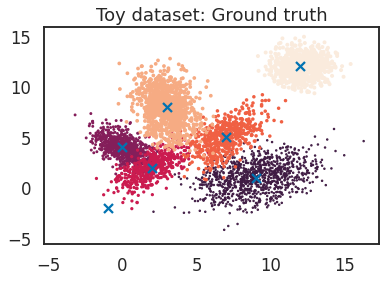

In [6]:
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

## Task 1: Cluster the data using k-Means

First, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. 

Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters, for instance 3, 5, 7, 10 and 20.

In [7]:
#means = np.array([np.random.uniform(-1.5,1.5,2) for i in range(7)])

#distances = [[np.linalg.norm(point - means[k]) for k in range(7)] for point in toy_norm]

#rnk = np.array([distances[i].index(min(distances[i])) for i in range(len(toy_norm))])

#means = [sum(toy_norm[rnk == k]) / sum(rnk==k) for k in range(7)]

In [8]:
def run_KMeans(data, n_clusters):
    '''Function that performs K-means clustering for a given number of clusters
        input:
            data: (n_samples, n_features)-shaped array of data
            number of clusters: int, number of clusters
        output:
            kmeans_result: (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
    '''

    # ---------------- INSERT CODE ----------------------
    data_norm = stdize(data)
    means = np.array([np.random.uniform(-1.5,1.5,2) for i in range(n_clusters)])
    
    for i in range(10):
        distances = [[np.linalg.norm(point - means[k]) for k in range(n_clusters)] for point in data_norm]
        rnk = np.array([distances[i].index(min(distances[i])) for i in range(len(data_norm))])
        
        means = [sum(data_norm[rnk == k]) / sum(rnk==k) for k in range(n_clusters)]
    
    
    
    kmeans_result = rnk #, np.array(means)
    # ---------------- END CODE -------------------------
    return kmeans_result

In [9]:
# run kmeans with different numbers of clusters

# ---------------- INSERT CODE ----------------------
labels_for_cluster_nr = [run_KMeans(toy_data, i) for i in (1,2,3,4,5,6,7,8,9,10,15,20,30)]
# ---------------- END CODE -------------------------

Plot your results as cluster labels using the "plot_clustering" function and compare it to the original cluster labels. Describe your results.

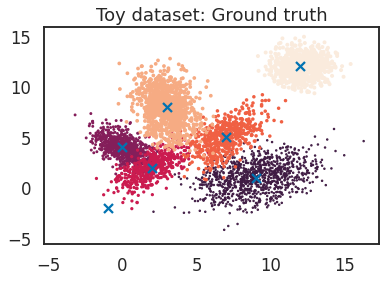

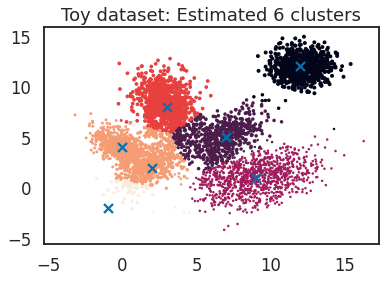

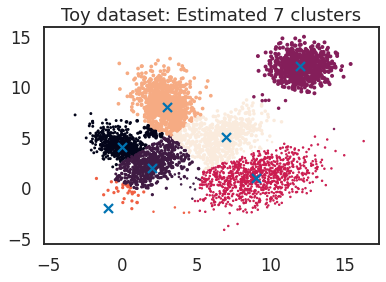

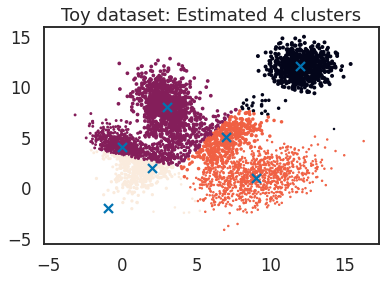

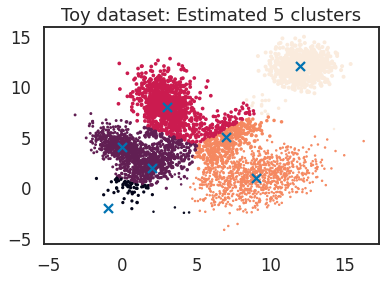

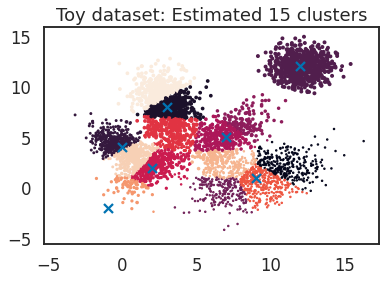

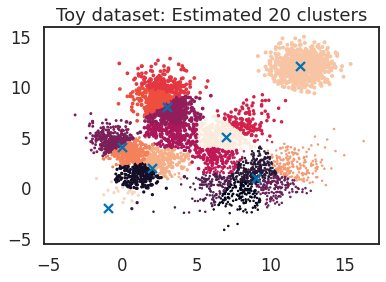

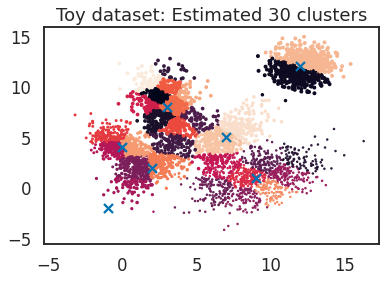

In [10]:
# plot results
# ---------------- INSERT CODE ----------------------
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')
plot_clustering(toy_data, labels_for_cluster_nr[5], toy_means, 'Toy dataset: Estimated 6 clusters')
plot_clustering(toy_data, labels_for_cluster_nr[6], toy_means, 'Toy dataset: Estimated 7 clusters')
plot_clustering(toy_data, labels_for_cluster_nr[3], toy_means, 'Toy dataset: Estimated 4 clusters')
plot_clustering(toy_data, labels_for_cluster_nr[4], toy_means, 'Toy dataset: Estimated 5 clusters')
plot_clustering(toy_data, labels_for_cluster_nr[10], toy_means, 'Toy dataset: Estimated 15 clusters')
plot_clustering(toy_data, labels_for_cluster_nr[11], toy_means, 'Toy dataset: Estimated 20 clusters')
plot_clustering(toy_data, labels_for_cluster_nr[12], toy_means, 'Toy dataset: Estimated 30 clusters')
# ---------------- END CODE -------------------------

YOUR ANSWER HERE

##  Task 2: Clustering using Gaussian Mixture Models

Next, we will implement clustering with Gaussian Mixture models ss discussed in the Bishop in Chapter 9.2.2 pg. 435-439.

Implement the EM algorithm to fit a Gaussian mixture model on the data. Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-5}$) to the diagonal.

In order to speed up the computation, define a convergence criterion that stops the algorithm after convergence.

In [11]:
# cov update old very tough bottleneck!!!
#samples = N_total
#clusters = 7
#helper_list = [0] * samples
#for i in range(samples):
#    for j in range(clusters):
#        centered_x = toy_data[i:i+1] - means[j:j+1]
#        helper_list[i] = responsibilities[i,j] * centered_x.T @ centered_x
#        covs[j] = 1/N_groups[j] * sum(helper_list)

In [15]:
def gmm(data, n_clusters, verbose=True, max_iter=1000, convergence_threshold=1e-4):
    '''Function that fits a mixture of gaussians to data.

        inputs:
            data          -- (n_samples, n_features)-shaped array of data points
            n_clusters    -- int, number of clusters / mixture components
            verbose       -- bool, if True, print current likelihood after each EM iteration
            max_iter      -- maximum number of EM iterations
            convergence_threshold  -- stop algorithm if change in log-lieklihood is below the treshold

        outputs:
            cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
            means       -- (n_clusters, n_features)-shaped array of fit mean vectors
            covs        -- (n_features, n_features,n_cluster)-shaped array of fit covariance matrices
            priors      -- (n_cluster)-shaped arrays of fit priors / mixing coefficients
        '''

    # ---------------- INSERT CODE ----------------------
    
    from scipy.stats import multivariate_normal
    
    n_samples, n_features = data.shape
    data_norm = stdize(data)
    
    ### INITIALIZATION ###
    means = np.array([np.random.uniform(-1.5,1.5,n_features) for i in range(n_clusters)])
    covs = [np.eye(n_features)] * n_clusters
    priors = np.random.uniform(0,1,n_clusters)

    ### ALTERNATE BETWEEN E & M STEP ###
    for loop_count in range(10):
    

        ### E-STEP ###
        denominator_matrix = np.array(
            [ [priors[j] * multivariate_normal.pdf(datapoint, mean=means[j], cov=covs[j]) for j in range(n_clusters)] 
             for datapoint in data_norm])
        #divide denominator matrix by its rowSums via transposing-trick
        responsibilities = (denominator_matrix.T/denominator_matrix.sum(axis=1)).T

        
        ### M-STEP ###
        N_groups = responsibilities.sum(axis = 0)
        priors = N_groups/n_samples
        means = [1/N_groups[k] * sum([responsibilities.T[k][i] * data_norm[i] for i in range(len(data_norm))]) for k in range(n_clusters)]

        #update covariance matrix
        weighted_demeaned_obs = [[responsibilities[i,j] * (data_norm[i:i+1]-means[j:j+1]).T @ (data_norm[i:i+1]-means[j:j+1]) for j in range(n_clusters)] for i in range(n_samples)]
        colsums = np.array(weighted_demeaned_obs).sum(axis = 0)
        covs = [1/N_groups[k] * colsums[k] for k in range(n_clusters)]
        
        
        ### CHECK FOR CONVERGENCE/ PRINT LOG_LIKELIHOOD if VERBOSE ###
        loglik_contribs = np.array([[
            sum(multivariate_normal.pdf(datapoint, mean=means[k], cov=covs[k]) for k in range(n_clusters))
            ] for datapoint in data_norm])

        loglik = sum(np.log(loglik_contribs))
        
        if verbose == True:
            print('Iteration: {}'.format(loop_count+1))
            print('Loglik: {}'.format(loglik))

    ### ASSIGN CLUSTER LABELS ###
    
    cluster_ids = [resp_row.index(min(resp_row)) for resp_row in responsibilities.tolist()]
    
    # ---------------- END CODE -------------------------

    return (cluster_ids, means, covs, priors)

Explore the results of GMM using different numbers of clusters and initialization strategies.

In [ ]:
# fit GMM
cluster_ids, means, covs, priors = gmm(toy_data, 7, verbose=True, max_iter=1000, convergence_threshold=1e-4)

Iteration: 1
Loglik: [-3705.73670668]
Iteration: 2
Loglik: [-3534.16707823]
Iteration: 3
Loglik: [-3336.11584001]
Iteration: 4
Loglik: [-3119.96356793]
Iteration: 5
Loglik: [-2871.88055382]
Iteration: 6
Loglik: [-2622.73798641]


Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? How does it compare to the k-Means solution? Plot ground truth, k-Means and GMM cluster assignment side-by-side to compare them.

If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

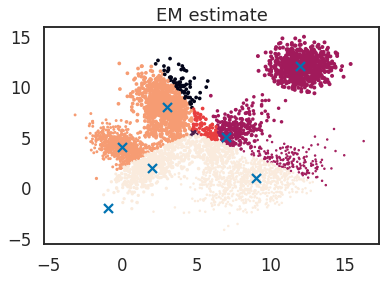

In [14]:
# plotting
plot_clustering(toy_data, cluster_ids, toy_means, 'EM estimate')

YOUR ANSWER HERE